# 0. 구글 드라이브와 연결 및 각종 라이브러리 설정

### 구글 드라이브 연동

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 필수 라이브러리 설치

In [2]:
!pip install mxnet 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.8 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
!pip install gluonnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 28.2 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595726 sha256=f1f3181af4e2110b4ee38f028f1cf59ba1467bcaa9b3e700a3a89fcaced6535d
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 21.8 MB/s 
     |████████████████████████████████| 596 kB 58.7 MB/s 
     |████████████████████████████████| 101 kB 13.6 MB/s 
     |████████████████████████████████| 6.6 MB 50.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=ca6762161481d8b8c50785cd1eae84d483651e87df5c177b46abdf5840bd720c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 32.9 MB/s 


### 필수 라이브러리 로드

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tensorflow as tf

from keras.callbacks import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 폴더 경로 지정

In [9]:
path = '/content/gdrive/MyDrive/FINAL_SUBMIT/'

# 1. 데이터 로드

### 데이터 로드 및 최종 점검

In [10]:
data = pd.read_excel(path + 'final_data.xlsx', engine='openpyxl')

In [11]:
data.head(2)

,Unnamed: 0,document,label
0,0,어릴 때 보고 지금 다시 봐도 재밌어ㅋㅋ,1
1,1,디자인을 배우는 학생으로 외국 디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...,1


# 2. 학습용 데이터와 테스트용 데이터 나누기

In [12]:
train_data, test_data = train_test_split(data, test_size = 0.25, shuffle=True, 
                                         stratify = data['label'], random_state=42)

In [13]:
# 따로 저장이 필요할 경우 아래 주석 처리 해제하여 사용 

#train_data.to_csv(path + 'final_train_data.txt', sep = '\t', index = False)
#test_data.to_csv(path + 'final_test_data.txt', sep = '\t', index = False)

# 3. GPT2 모델링

### 3-1. GPT2Model 클래스 구현 및 프리트레인된 파라미터 다운로드  

In [14]:
# 모델 학습에 필요한 3개의 모듈 import
import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from transformers import *

In [15]:
# 불러온 모델을 활용해 여기서 사용할 모델 클래스를 구현
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)

    def call(self, inputs):
        return self.gpt2(inputs)[0]

In [16]:
# 구현된 모델 클래스에 프리트레인된 파라미터를 다운로드
import wget
import zipfile

wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')
with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

In [17]:
# 다음 경로로 파라미터를 이동시킨 후 모델을 선언
# 경로에는 반드시 config.json과 tf.model.h5 파일이 있어야 함
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

loading configuration file ./gpt_ckpt/config.json
Model config GPT2Config {
  "activation_function": "gelu",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.21.1",
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file ./gpt_ckpt/tf_model.h5
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model c

### 3-2. GPT2 토크나이저 생성 후 train data 토큰화



In [18]:
# 후에 사용할 주요 변수들 정의
MAX_LEN = 25 # okt 형태소 분석기로 분석했을 때 95%의 데이터들이 살아남은 지점의 길이
NUM_EPOCHS = 3 # accuracy가 가장 좋았던 수치로 선정
BATCH_SIZE = 64 # accuracy가 가장 좋았던 수치로 선정
VALID_SPLIT = 0.1

In [19]:
# 토크나이저 생성
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'
tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=-1) # 여기서 num_best를 반드시 설정해줘야함
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH, 
                                               mask_token=None, 
                                               sep_token='<unused0>', 
                                               cls_token=None, 
                                               unknown_token='<unk>',  
                                               padding_token='<pad>', 
                                               bos_token='<s>', 
                                               eos_token='</s>')

In [20]:
# 토크나이저를 활용해 train data 토큰화
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
    train_tokenized_text = vocab[tokenizer(train_sent)] 

    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([train_tokenized_text], 
                            maxlen=MAX_LEN,
                            value=vocab[vocab.padding_token], 
                            padding='pre').tolist()[0]
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

### 3-3. GPT2Classifier 클래스 구현 및 모델 compile 수행

In [21]:
# 모델 학습에 앞서 GPT2 텍스트 분류기를 만들기 위해 TFGPT2Classifier라는 클래스를 구현
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class

        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        gpt_output =outputs[0][:, -1]

        pooled_output = self.dropout(gpt_output)
        logits = self.classifier(pooled_output)

        return logits

In [22]:
# optimizer, loss, metric 지정 후 model.compile 수행 -> 모델 학습 준비 완료
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

optimizer = tf.keras.optimizers.Adam(6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

loading configuration file ./gpt_ckpt/config.json
Model config GPT2Config {
  "activation_function": "gelu",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.21.1",
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file ./gpt_ckpt/tf_model.h5
All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at

### 3-4. 토큰화된 train data로 GPT2 모델에 훈련


In [24]:
# 학습을 진행할 때는 GPU로 학습하는 것을 권장함
model_name = 'gpt2_model_final'

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

# 가중치 파일(weights.h5)이 저장될 경로 지정
checkpoint_path = os.path.join(path, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else: 
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor="val_accuracy", 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
)

with tf.device('/device:GPU:0'):
    history = cls_model.fit(
        train_data_sents, 
        train_data_labels, 
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE, 
        validation_split=VALID_SPLIT,
        callbacks=[earlystop_callback, cp_callback] 
    )

/content/gdrive/MyDrive/FINAL_SUBMIT/gpt2_model_final -- Folder create complete 

Epoch 1/3
3092/3092 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.8386
Epoch 1: val_accuracy improved from -inf to 0.86540, saving model to /content/gdrive/MyDrive/FINAL_SUBMIT/gpt2_model_final/weights.h5
3092/3092 [==============================] - 1170s 373ms/step - loss: 0.3639 - accuracy: 0.8386 - val_loss: 0.3160 - val_accuracy: 0.8654
Epoch 2/3
3092/3092 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8767
Epoch 2: val_accuracy improved from 0.86540 to 0.87604, saving model to /content/gdrive/MyDrive/FINAL_SUBMIT/gpt2_model_final/weights.h5
3092/3092 [==============================] - 1156s 374ms/step - loss: 0.2917 - accuracy: 0.8767 - val_loss: 0.3013 - val_accuracy: 0.8760
Epoch 3/3
3092/3092 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.8953
Epoch 3: val_accuracy improved from 0.87604 to 0.87845, saving model to /content

- [Epoch 1/3] accuracy: 0.8386, val_accuracy: 0.8654
- [Epoch 2/3] accuracy: 0.8767, val_accuracy: 0.8760
- [Epoch 3/3] accuracy: 0.8953, val_accuracy: 0.8785

In [25]:
# 모델 구조를 출력
cls_model.summary()

Model: "tfgpt2_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tfgpt2_model (TFGPT2Model)  multiple                  124242432 
                                                                 
 dropout_74 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 124,243,970
Trainable params: 124,243,970
Non-trainable params: 0
_________________________________________________________________


### 3-5. test data 토큰화 후 훈련된 GPT2 모델에 검증

In [26]:
# 토크나이저를 활용해 test data 토큰화
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document', 'label']].values:
    test_tokenized_text = vocab[tokenizer(test_sent)] 

    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([test_tokenized_text], 
                            maxlen=MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='pre').tolist()[0]
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [27]:
cls_model.load_weights(checkpoint_path)

results = cls_model.evaluate(
    test_data_sents, 
    test_data_labels, 
    batch_size=BATCH_SIZE
)
print("test loss, test acc: ", results)

1145/1145 [==============================] - 133s 116ms/step - loss: 0.2959 - accuracy: 0.8801
test loss, test acc:  [0.29587987065315247, 0.8800715208053589]


- test data accuracy: 0.8801  

### 3-6. 훈련된 GPT2 모델의 f1-score 계산 및 confusion matrix 출력

In [28]:
test_predict = cls_model.predict(test_data_sents)

In [29]:
test_predict[:10]
# 형태를 보니 시그모이드 함수로 변환해야 할 것 같음

array([[ 1.0002668 , -0.69663155],
       [ 2.7471027 , -2.6422775 ],
       [-0.26886168,  0.36768368],
       [ 0.2669178 , -0.10669188],
       [-2.3719664 ,  2.4731793 ],
       [ 1.7257535 , -1.524921  ],
       [ 3.1917813 , -2.9027948 ],
       [ 1.5423253 , -1.3872244 ],
       [ 2.586126  , -2.3861508 ],
       [ 2.8921561 , -2.6763763 ]], dtype=float32)

test_predict 형태를 보니 sigmoid 함수로 변환 필요

In [30]:
# 시그모이드 함수로 값 변환
test_predict_tf = tf.keras.activations.sigmoid(test_predict)

# tf.Tensor 파일을 다시 numpy 배열 형태로 변환
test_predict_sigmoid = test_predict_tf.numpy()

In [31]:
# 변환 결과 확인
test_predict_sigmoid

array([[0.731111  , 0.33255947],
       [0.9397495 , 0.06646658],
       [0.4331866 , 0.59089917],
       ...,
       [0.05491803, 0.9529018 ],
       [0.4643704 , 0.5722563 ],
       [0.9520363 , 0.0558136 ]], dtype=float32)

In [32]:
# 최종 예측 결과가 0 또는 1이 되게끔 변환
test_predict_final = []

for prob in test_predict_sigmoid:
    if prob[0] > prob[1]:
        test_predict_final.append(0)
    elif prob[0] < prob[1]:
        test_predict_final.append(1)

print(test_predict_final)

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 

In [34]:
# accuracy와 f1_score가 제대로 나오는지 확인
print('accuracy:',sklearn.metrics.accuracy_score(test_predict_final, test_data_labels))
print('f1 score:',sklearn.metrics.f1_score(test_predict_final, test_data_labels))

accuracy: 0.8800715094777352
f1 score: 0.8375600739371534


accuracy와 f1-score를 confusion_matrix로 시각화

              precision    recall  f1-score   support

           0       0.92      0.89      0.90     46970
           1       0.82      0.86      0.84     26307

    accuracy                           0.88     73277
   macro avg       0.87      0.88      0.87     73277
weighted avg       0.88      0.88      0.88     73277



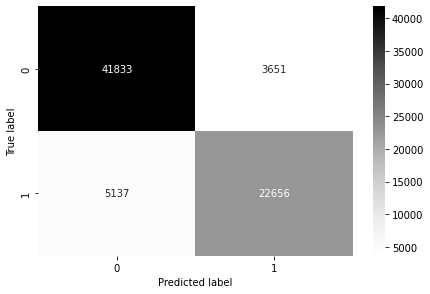

In [35]:
%matplotlib inline  
def visualize_confusion_matrix(y_pred_argmax, y_true):
    cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred_argmax, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Greys)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

visualize_confusion_matrix(test_predict_final, test_data_labels)

# END